In [1]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [2]:
dataset = pd.read_csv("train.csv")
final_test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [3]:
dataset.shape

(15819, 3)

In [4]:
final_test.shape

(10546, 2)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [6]:
dataset.head(2)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103


In [7]:
final_test.head(2)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326


In [40]:
y = dataset['sentiment']
X = dataset.drop(columns=['sentiment', 'tweetid'])
F_test = final_test.drop(columns='tweetid')

In [9]:
X.head(2)

,message
0,PolySciMajor EPA chief doesn't think carbon di...
1,It's not like we lack evidence of anthropogeni...


In [10]:
y.unique()

array([ 1,  2,  0, -1], dtype=int64)

In [33]:
text = X.iloc[6,0]
print(text)

RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R


In [12]:
import matplotlib
matplotlib.pyplot.rcdefaults()

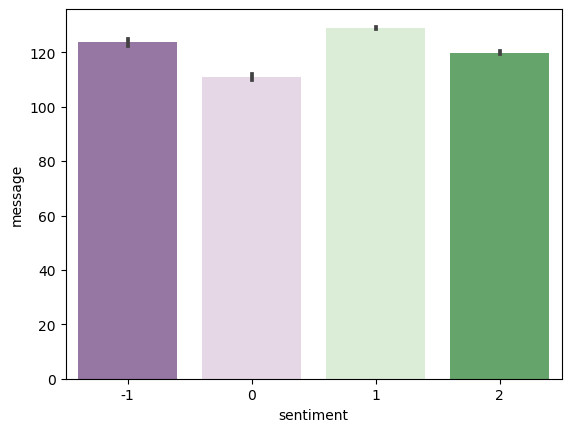

In [13]:
sns.barplot(x='sentiment', y=dataset['message'].apply(len) ,data = dataset,palette='PRGn')

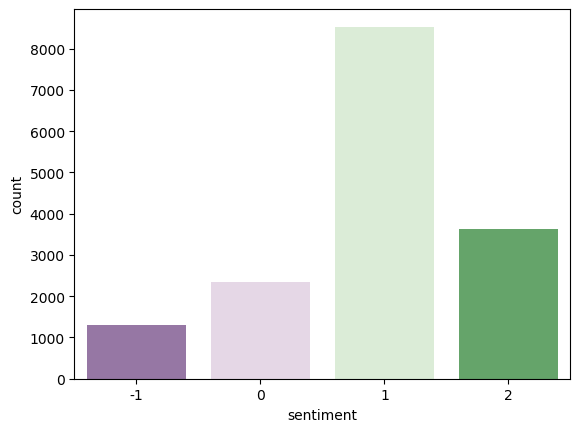

In [14]:
sns.countplot(x='sentiment' ,data = dataset,palette='PRGn')

Preprocessing

1. I will remove all the users, "@" 
2. Tokenize
3. Remove panctuation
4. lowercases
5. lemmatize

firstly, i want to see if any of the users are repeated.

In [15]:
working_x = dataset.copy()

In [16]:
working_x['users'] = [''.join(re.findall(r'@\w{,}', line)) if '@' in line else np.nan for line in X.message]



In [17]:
counts = working_x[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [262]:
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


In [261]:
counts['message'][counts['message'] > 1].sum()/len(counts['message'])

0.8567911960613959

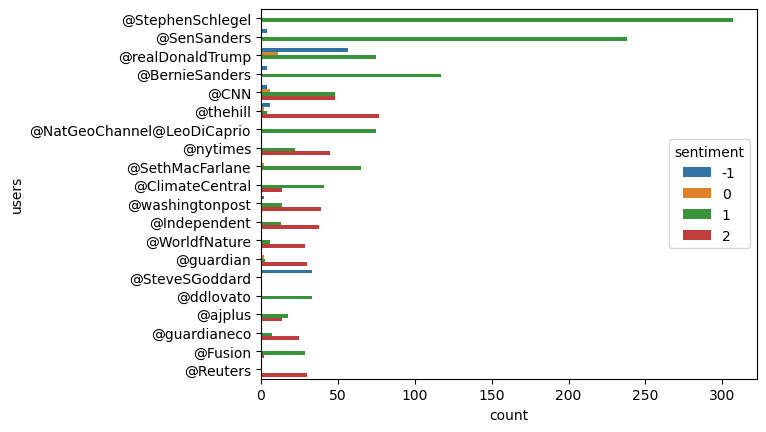

In [264]:
sns.countplot(y="users", hue="sentiment", data=working_x,
              order=working_x.users.value_counts().iloc[:20].index)
#plt.xticks(rotation=90)

I will not be removing users, as we can see that they have contribute to the analysis

In [24]:
X

,message
0,PolySciMajor EPA chief doesn't think carbon di...
1,It's not like we lack evidence of anthropogeni...
2,RT @RawStory: Researchers say we have three ye...
3,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."
...,...
15814,RT @ezlusztig: They took down the material on ...
15815,RT @washingtonpost: How climate change could b...
15816,notiven: RT: nytimesworld :What does Trump act...
15817,RT @sara8smiles: Hey liberals the climate chan...


In [256]:
def cleaner(line):

    line = re.sub(r'^RT ','', re.sub(r'https://t.co/\w+', '', line).strip()) # Removes RT and url

    punctuation = re.compile("[.;:@!\'’‘“”?,\"()\[\]]")
    tweet = REPLACE_NO_SPACE.sub("", line.lower()) # Removes puctuation

    return tweet

In [259]:
text1 = cleaner(text)
print(text1)

thenation mike pence doesnt believe in global warming or that smoking causes lung cancer


In [265]:
text

'RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R'